In [50]:
import json
import os
import sys

from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

if os.path.abspath("../io") not in sys.path:
    sys.path.append(os.path.abspath("../io"))

if os.path.abspath("../war_exp") not in sys.path:
    sys.path.append(os.path.abspath("../war_exp"))

from read import read_dataset, read_label, read_trial, get_trial_info
from utils import NumpyEncoder
from experiments import cv_fit, run_classifier_comparison, movement_onset_experiment
from plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_roc_cv,
    plot_feature_importances,
    plot_cv_indices,
    plot_accuracies
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [51]:
def filter_epochs(epochs, resample_rate=500):
    # Low-pass filter up to sfreq/2
    fs = epochs.info["sfreq"]
    new_epochs = epochs.filter(l_freq=0.5, h_freq=fs/2-1)

    # Downsample epochs to 500 Hz
    new_epochs = new_epochs.resample(resample_rate)

    return new_epochs

<IPython.core.display.Javascript object>

In [53]:
bids_root = Path("/Volumes/Mac/research/data/efri")

# subject identifiers
path_identifiers = dict(subject="efri02", session="efri", task="move", acquisition="seeg", run="01", suffix="ieeg", extension=".vhdr", root=bids_root)


bids_path = BIDSPath(**path_identifiers)

results_path = Path(
    "/Users/ChesterHuynh/Johns Hopkins/Adam Li - efri/derivatives/workstation_output"
)
# destination = results_path / "movement_onset_experiment"

<IPython.core.display.Javascript object>

In [5]:
before = read_dataset(bids_path, kind='ieeg', tmin=0, tmax=1.0, picks=None, event_key="At Center", verbose=True)
before.load_data()
before_data = filter_epochs(before).get_data()

## tmin=-0.25 to capture initiation of mvmt
after = read_dataset(bids_path, kind='ieeg', tmin=-0.25, tmax=0.75, picks=None, event_key="Left Target", verbose=True)
after.load_data()
after_data = filter_epochs(after).get_data()

Extracting parameters from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 135 trials, there were 132 successful trials in /workspaces/research/mnt/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Leave Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Not setting metadata
Not setting metadata
135 matching events found
No baseline correction applied
0 proje

In [6]:
ntrials, nchs, nsteps = before_data.shape

X = np.vstack([
    before_data.reshape(before_data.shape[0], -1),  # class 0
    after_data.reshape(after_data.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_data)),
    np.ones(len(after_data))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of samples"

print(X.shape, y.shape)

(267, 32000) (267,)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


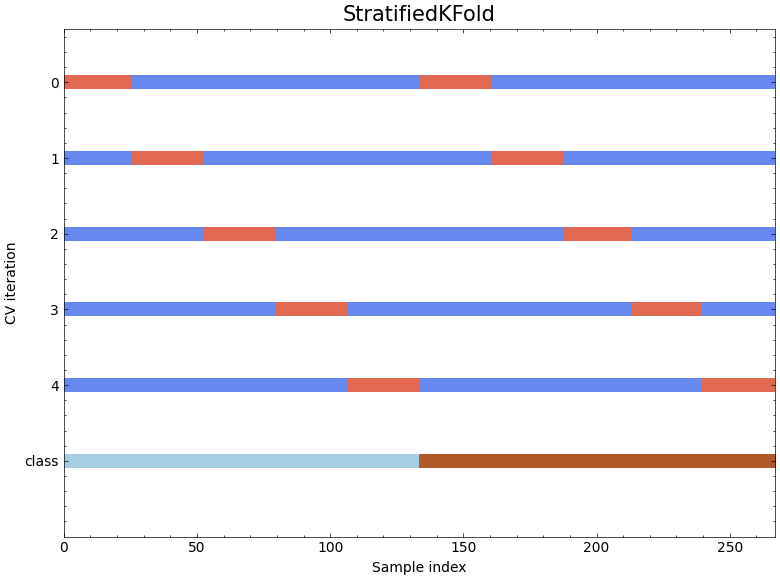

In [7]:
# Perform K-Fold cross validation
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
fig.tight_layout();

In [8]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

### Time domain

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


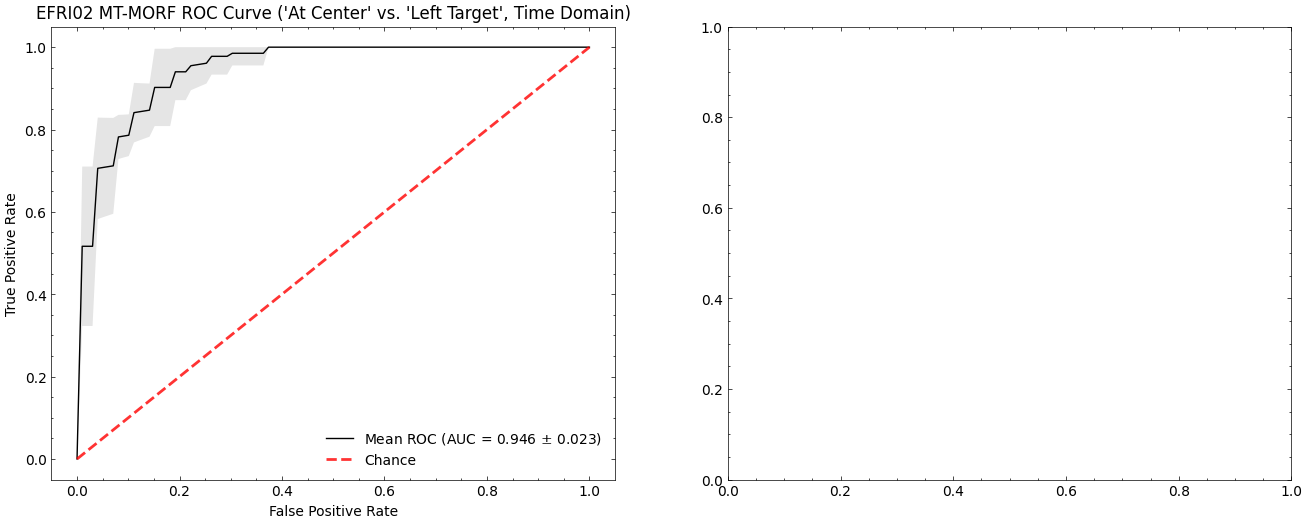

In [8]:
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

## Cross validation. Fit model
stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs.flatten()

plot_roc_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=axs[0],
)

axs[0].set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', Time Domain)",
)
axs[0].legend(loc="lower right");

In [9]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

## Plot results
plot_accuracies(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', Time Domain)")
fig.tight_layout()

domain = "time"
plt.savefig(destination / f"movement_onset_{domain}_domain.png")
plt.show()

100%|██████████| 5/5 [05:56<00:00, 71.37s/it]


<Figure size 432x288 with 0 Axes>

### Freq domain
- `TODO`: For loop for each patient

In [9]:
nfreqs = 10
lfreq, hfreq = (70, 200)
freqs = np.logspace(*np.log10([lfreq, hfreq]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency

after_power = tfr_morlet(after, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1).data
before_power = tfr_morlet(before, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1).data

Not setting metadata
Not setting metadata


In [10]:
ntrials, nchs, nfreqs, nsteps = before_power.shape

X = np.vstack([
    before_power.reshape(before_power.shape[0], -1),  # class 0
    after_power.reshape(after_power.shape[0], -1)     # class 1
])
y = np.concatenate([
    np.zeros(len(before_power)),
    np.ones(len(after_power))
])

assert X.shape[0] == y.shape[0], "X and y do not have the same number of epochs"

print(X.shape, y.shape)

(267, 106880) (267,)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


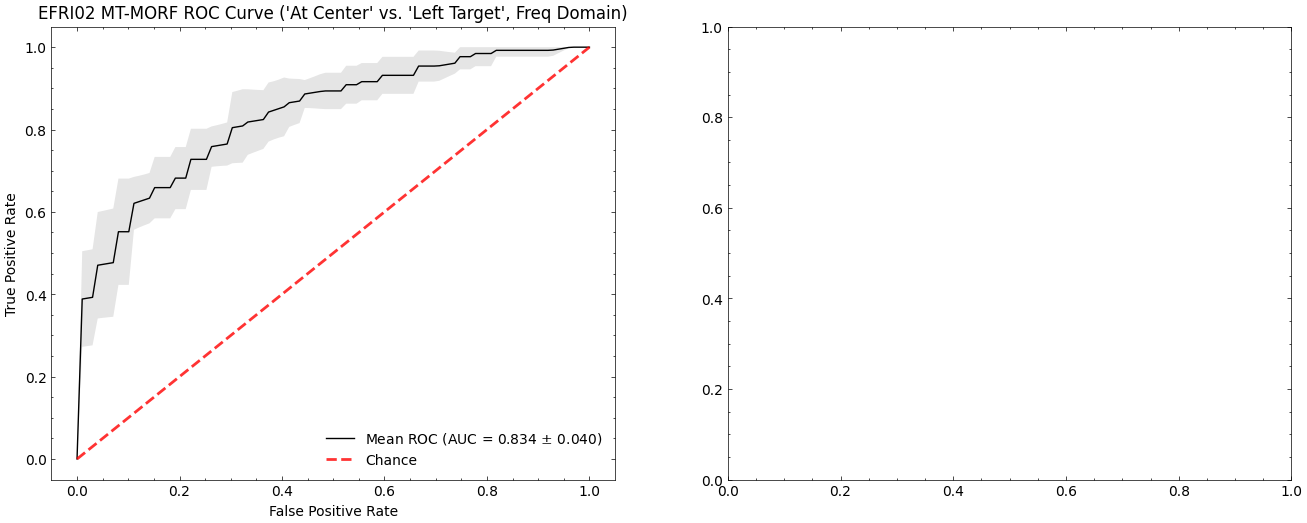

In [11]:
# Perform K-Fold cross validation
rng = 1
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

## Cross validation. Fit model
stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

## Plot results
fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(16, 6))
axs = axs.flatten()

plot_roc_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=axs[0],
)

axs[0].set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF ROC Curve ('At Center' vs. 'Left Target', Freq Domain)",
)
axs[0].legend(loc="lower right");

In [12]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs*nfreqs,
    image_width=nsteps,
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

plot_accuracies(clf_scores, ax=axs[1])
axs[1].set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers ('At Center' vs. 'Left Target', Freq Domain)")
fig.tight_layout()

domain = "frequency"
plt.savefig(destination / f"movement_onset_{domain}_domain.png")
plt.show();

  0%|          | 0/5 [00:00<?, ?it/s]